In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-word-correction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2523432%2F4302023%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T105131Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D300347a63f8f7cceb17e48f7994242dd058f9020a4fe5099bc4633d59f38ef67ba6354ae963e3a6ed5d6b6cde665e8a91cd9505fdf3049b40a4fa1a5d8c53b251c33cd682570283777c180ad90bbfac69c6aaeccebc0e8d96e447696b1017d9fc472a19e1f5fdd753dffc8099721f6c7bac7dea802aaacdef38e05e63acc779ca971c90b655aee77143ca4b49fd25553d2c05e4f0ba17b08ec1a7a4a5f410ac488cbd77cdf4a3854a60ffd86473a798bd71f52f709c0162208549c0e86354760c9dce017a75b810e5f8e294094a6c01b38526ff47902e68c571708378d4490587e5d02f26c370137ad2ed960b2c93b0afe874272e66904468988d34551a77b2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1807746 bytes downloaded
Downloaded and uncompressed: nlp-word-correction
Data source import complete.


In [1]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-word-correction/All_train_data.csv
/kaggle/input/nlp-word-correction/NLP Assignment/val_data.csv
/kaggle/input/nlp-word-correction/NLP Assignment/train_data.csv
/kaggle/input/nlp-word-correction/NLP Assignment/sample_submission.csv
/kaggle/input/nlp-word-correction/NLP Assignment/test_data.csv
/kaggle/input/nlp-word-correction/NLP Assignment/test_data.xlsx


In [44]:
df = pd.read_csv("/kaggle/input/nlp-word-correction/All_train_data.csv")
df

,input,labels
0,I am reading score of Mahler is Symphony No . .,0
1,I am not interested in cars or electric applia...,1
2,This is my homework for my English class .,0
3,"In comparison , Canada is catches increased an...",0
4,"Fortunately , my older sister is friend is a d...",1
...,...,...
29993,"Actually , I started college this April even t...",1
29994,I am sure we all get more sophisticated as we ...,1
29995,I am worried about my English lessons and the ...,1
29996,It is okay to change the meaning though .,0


## Data Exploration and Preprocessing

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   29998 non-null  object
 1   labels  29998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB


In [46]:
df['labels'].value_counts()

,count
labels,
0,14999
1,14999


The dataset is balanced so we can proceed with splitting it now

In [47]:
df.isnull().sum()

,0
input,0
labels,0


In [48]:
df.duplicated().sum()

466

In [49]:
df.drop_duplicates(inplace=True)

In [50]:
df.duplicated().sum()

0

## Text Preprocessing

In [51]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [53]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [54]:
stopwords = list(stop_words)

In [55]:
def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuation but keep some meaningful ones
    text = re.sub(r'[^\w\s!?]', '', text)

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    return ' '.join(words)

In [56]:
df

,input,labels
0,I am reading score of Mahler is Symphony No . .,0
1,I am not interested in cars or electric applia...,1
2,This is my homework for my English class .,0
3,"In comparison , Canada is catches increased an...",0
4,"Fortunately , my older sister is friend is a d...",1
...,...,...
29993,"Actually , I started college this April even t...",1
29994,I am sure we all get more sophisticated as we ...,1
29995,I am worried about my English lessons and the ...,1
29996,It is okay to change the meaning though .,0


In [57]:
X = df['input']
y= df['labels']

In [58]:
X_cleaned = [clean_text(doc) for doc in X]
scaler = TfidfVectorizer(ngram_range=(1, 2))
X_scaled= scaler.fit_transform(X_cleaned)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [63]:
# Define the Naive Bayes Classifier with Laplace smoothing
class NaiveBayesTextClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_log_priors = {}
        self.feature_log_probs = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        # Calculate class priors
        for c in self.classes:
            self.class_log_priors[c] = np.log((y == c).sum() / n_samples)

        # Calculate feature probabilities with Laplace smoothing
        for c in self.classes:
            X_c = X[y == c]
            N_c = X_c.sum(axis=0) + self.alpha
            self.feature_log_probs[c] = np.log(N_c / N_c.sum())

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            class_scores = {}
            for c in self.classes:
                class_scores[c] = self.class_log_priors[c] + X[i].dot(self.feature_log_probs[c].T)[0, 0]
            predictions.append(max(class_scores, key=class_scores.get))

        return predictions

In [64]:
final_classifier = NaiveBayesTextClassifier(alpha=1.0)
final_classifier.fit(X_scaled, y)

# Prepare test set and predict
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
final_predictions = final_classifier.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f"Final Test Set Accuracy: {final_accuracy:.4f}")

Final Test Set Accuracy: 0.6887


In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

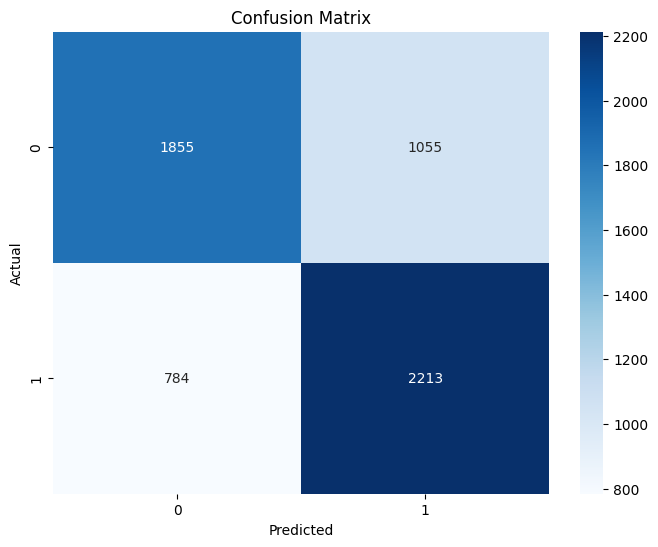

In [68]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [69]:
class_report = classification_report(y_test, final_predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67      2910
           1       0.68      0.74      0.71      2997

    accuracy                           0.69      5907
   macro avg       0.69      0.69      0.69      5907
weighted avg       0.69      0.69      0.69      5907



In [71]:
from sklearn.preprocessing import label_binarize

ROC-AUC Score: 0.6879


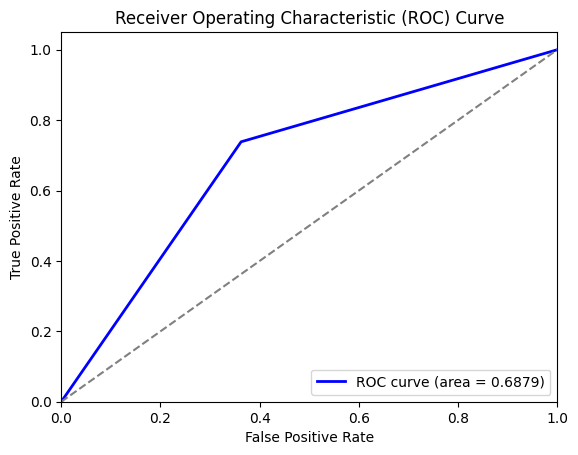

In [72]:
if len(np.unique(y)) == 2:
    # Binarize the output for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))
    pred_binarized = label_binarize(final_predictions, classes=np.unique(y))

    roc_auc = roc_auc_score(y_test_binarized, pred_binarized)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test_binarized, pred_binarized)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [73]:
def make_inference(input_text):
    """
    Function to take a new input, clean it, vectorize it, and make a prediction.
    """
    # Preprocess the input
    cleaned_text = clean_text(input_text)

    # Vectorize the cleaned input
    vectorized_input = scaler.transform([cleaned_text])

    # Predict using the trained classifier
    prediction = final_classifier.predict(vectorized_input)

    return prediction[0]


In [93]:
sample_text = "This is my homework for my English class"
prediction = make_inference(sample_text)
print(f"The sentence '{sample_text}' is classified as: {prediction}")

The sentence 'This is my homework not has been English class' is classified as: 1


In [87]:
print(df[df['labels']==0])

                                                   input  labels
0        I am reading score of Mahler is Symphony No . .       0
2             This is my homework for my English class .       0
3      In comparison , Canada is catches increased an...       0
7                                              See you .       0
9                                       biodiversity n .       0
...                                                  ...     ...
29987  Someone described the generation after s was a...       0
29988          From now , I begin to keep a diary again        0
29990  My brother had been there about days , and he ...       0
29992  I will try harder studying Russian and English...       0
29996          It is okay to change the meaning though .       0

[14803 rows x 2 columns]


In [94]:
import pickle as pkl

In [98]:
with open('naivebayes.pkl', 'wb') as f:
    pkl.dump(final_classifier, f)

In [99]:
with open('/content/naivebayes.pkl', 'rb') as f:
    loaded_classifier = pkl.load(f)

In [103]:
!pip install gingerit


  Preparing metadata (setup.py) ... done
  Created wheel for gingerit: filename=gingerit-0.0.0.1-py3-none-any.whl size=1305 sha256=31bf5c3d801147a1fd8021a6c10527308b8996d19e5c41d73a0e448bbed4f457
  Stored in directory: /root/.cache/pip/wheels/56/e6/a2/52c79462716d18cf1fea30273884c0c2d6ddf2a90df58fda83
Successfully built gingerit


In [113]:
!pip install cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00


In [121]:
!pip install -U git+https://github.com/PrithivirajDamodaran/Gramformer.git


  Cloning https://github.com/PrithivirajDamodaran/Gramformer.git to /tmp/pip-req-build-r4uu8lcw
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Gramformer.git /tmp/pip-req-build-r4uu8lcw
  Resolved https://github.com/PrithivirajDamodaran/Gramformer.git to commit 23425cd2e98a919384cab6156af8adf1c9d0639a
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.8 MB/s eta 0:00:00
  Created wheel for gramformer: filename=gramformer-1.0-py3-none-any.whl size=4462 sha256=cd3db82d085e89a8890bfbdc170257c2999d97bd32802ef1240d9ab4d7f6bdb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-qsoo6bzt/wheels/76/44/15/e79b5dc4f5c897b2054e6a8e357f6de157b9554f072a2e56ea
Successfully built gramformer


In [128]:
from gramformer import Gramformer
gf = Gramformer(models=1)  # 1 for grammar correction


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


[Gramformer] Grammar error correct/highlight model loaded..


In [133]:
def make_inference_with_correction(input_text):
    """
    Function to take a new input, correct it, clean it, vectorize it, and make a prediction.
    """

    cleaned_text = clean_text(input_text)

    # Vectorize the cleaned input
    vectorized_input = scaler.transform([input_text])

    # Predict using the trained classifier
    prediction_bf= loaded_classifier.predict(vectorized_input)

    # Correct grammar using Gramformer
    corrected_texts = gf.correct(input_text)

    # If corrected_texts is a set, convert it to a list
    corrected_text = list(corrected_texts)[0] if corrected_texts else input_text  # Get the first corrected text

    # Preprocess the corrected input
    cleaned_text = clean_text(corrected_text)

    # Vectorize the cleaned input
    vectorized_input = scaler.transform([cleaned_text])

    # Predict using the trained classifier
    prediction_af = loaded_classifier.predict(vectorized_input)

    return prediction_bf[0], corrected_text, prediction_af[0]

In [142]:
# Example usage for inference with grammar correction
sample_text = "old how are you"
before_prediction, corrected_sentence, after_prediction = make_inference_with_correction(sample_text)
print(f"Original sentence: '{sample_text}'")
print(f"Corrected sentence: '{corrected_sentence}'")
print(f"The before correction sentence is classified as: {before_prediction}")
print(f"The After correction sentence is classified as: {after_prediction}")

Original sentence: 'old how are you'
Corrected sentence: 'old how are you?'
The before correction sentence is classified as: 1
The After correction sentence is classified as: 1
